In [81]:
#@title Packages

import pandas as pd
import numpy as np
import ast 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import seaborn as sns
from scipy.stats import zscore
from scipy.stats import mstats
from scipy.signal import savgol_filter
from scipy.signal import periodogram
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import joblib
import os
import warnings

In [82]:
#@title Merge Symbol Characteristics with Performance

characteristics_df = pd.read_csv('../Data/stocks_characteristics.csv')
results_df = pd.read_csv('../Data/final_results.csv')
merged_df = pd.merge(results_df, characteristics_df, on='Symbol', how='left')

merged_df.head()

,Symbol,RMSE,MSE,MAE,MAPE,R2,Accuracy,Precision,Recall,F1_Score,Price,Volume,Growth,Volatility,Seasonality,Sharpe Ratio,Max Drawdown
0,A,2.056108,4.227578,1.449661,1.126171,0.975601,49.700599,66.025641,47.247706,55.080214,111.92,4753647.0,0.044793,0.014572,0.090955,0.015522,-0.446174
1,AAL,3.306209,10.931018,2.367480,15.957711,-0.408859,66.766467,66.766467,100.000000,80.071813,11.41,62937838.0,0.005346,0.028818,0.113771,0.014457,-0.648722
2,AAP,12.092209,146.221517,10.492711,27.452196,-0.840940,42.514970,59.677419,34.259259,43.529412,47.93,2652963.0,-0.192811,0.025298,0.006222,-0.010848,-0.874705
3,AAPL,4.396692,19.330900,3.557611,1.592126,0.914903,53.293413,70.967742,56.410256,62.857143,200.85,70819942.0,0.200886,0.015717,0.037869,0.039737,-0.334337
4,ABBV,4.643506,21.562149,3.726010,2.003068,0.861271,51.497006,66.857143,52.941176,59.090909,186.11,11609036.0,0.154693,0.011950,0.022360,0.039013,-0.242627


In [83]:
#@title Analyze Performance for each Metric - PART 1

summary_stats = merged_df[['RMSE', 'MSE', 'MAE', 'MAPE', 'R2', 'Accuracy', 'Precision', 'Recall',  'F1_Score']].describe()
print(summary_stats)
print(f"\n{'='*70}")
summary_stats_2 = merged_df[['Price', 'Volume', 'Growth', 'Volatility', 'Seasonality', 'Sharpe Ratio', 'Max Drawdown']].describe()
print(summary_stats_2)

             RMSE            MSE         MAE        MAPE          R2  \
count  403.000000     403.000000  403.000000  403.000000  403.000000   
mean    15.473965    1522.273357   14.318532   10.853560   -4.249734   
std     35.861133   11955.045995   35.604268   15.466409   15.522836   
min      0.220909       0.048801    0.152366    0.677039 -146.936411   
25%      2.144789       4.600608    1.588553    1.424526   -1.280664   
50%      4.643506      21.562149    3.734035    2.884701    0.840551   
75%     13.391377     179.353641   11.950589   14.682488    0.944777   
max    469.857683  220766.242516  468.161156   95.741288    0.991777   

         Accuracy   Precision      Recall    F1_Score  
count  403.000000  403.000000  403.000000  403.000000  
mean    51.138913   66.984999   53.921337   59.383207  
std      4.014376    3.278185    9.689639    5.436028  
min     40.419162   57.142857   34.259259   43.529412  
25%     48.802395   64.602787   49.530506   56.145042  
50%     50.5988

In [84]:
variables = ['RMSE', 'MSE', 'MAE', 'MAPE', 'R2', 'Accuracy', 'Precision', 'Recall', 'F1_Score']
chars = ['Price', 'Volume', 'Growth', 'Volatility', 'Seasonality', 'Sharpe Ratio', 'Max Drawdown']

for column in variables:
    print(f"\n{'='*50}")
    print(f"{column.upper()}")
    print(f"{'='*50}")
    
    print(f"\nTop 5 HIGHEST {column}:")
    print("-" * 30)
    top_max = merged_df.nlargest(5, column)
    for idx, row in top_max.iterrows():
        print(f"\nSymbol: {row['Symbol']}")
        print(row[chars].to_string())  
    
    print(f"\nTop 5 LOWEST {column}:")
    print("-" * 30)
    top_min = merged_df.nsmallest(5, column)
    for idx, row in top_min.iterrows():
        print(f"\nSymbol: {row['Symbol']}")
        print(row[chars].to_string())


RMSE

Top 5 HIGHEST RMSE:
------------------------------

Symbol: TDG
Price            1468.43
Volume          374972.0
Growth          0.273435
Volatility        0.0155
Seasonality     0.002608
Sharpe Ratio    0.050486
Max Drawdown   -0.255723

Symbol: VRTX
Price              442.05
Volume          2581744.0
Growth           0.090555
Volatility       0.015152
Seasonality      0.013322
Sharpe Ratio     0.023397
Max Drawdown    -0.416001

Symbol: PNC
Price              173.81
Volume          4161485.0
Growth           0.086788
Volatility       0.015616
Seasonality      0.068598
Sharpe Ratio     0.022402
Max Drawdown    -0.515522

Symbol: MSI
Price              415.38
Volume          3176673.0
Growth           0.245019
Volatility       0.012443
Seasonality      0.017637
Sharpe Ratio     0.054488
Max Drawdown    -0.277674

Symbol: AXP
Price              294.05
Volume          5251753.0
Growth           0.249128
Volatility       0.016652
Seasonality      0.010764
Sharpe Ratio     0.044826

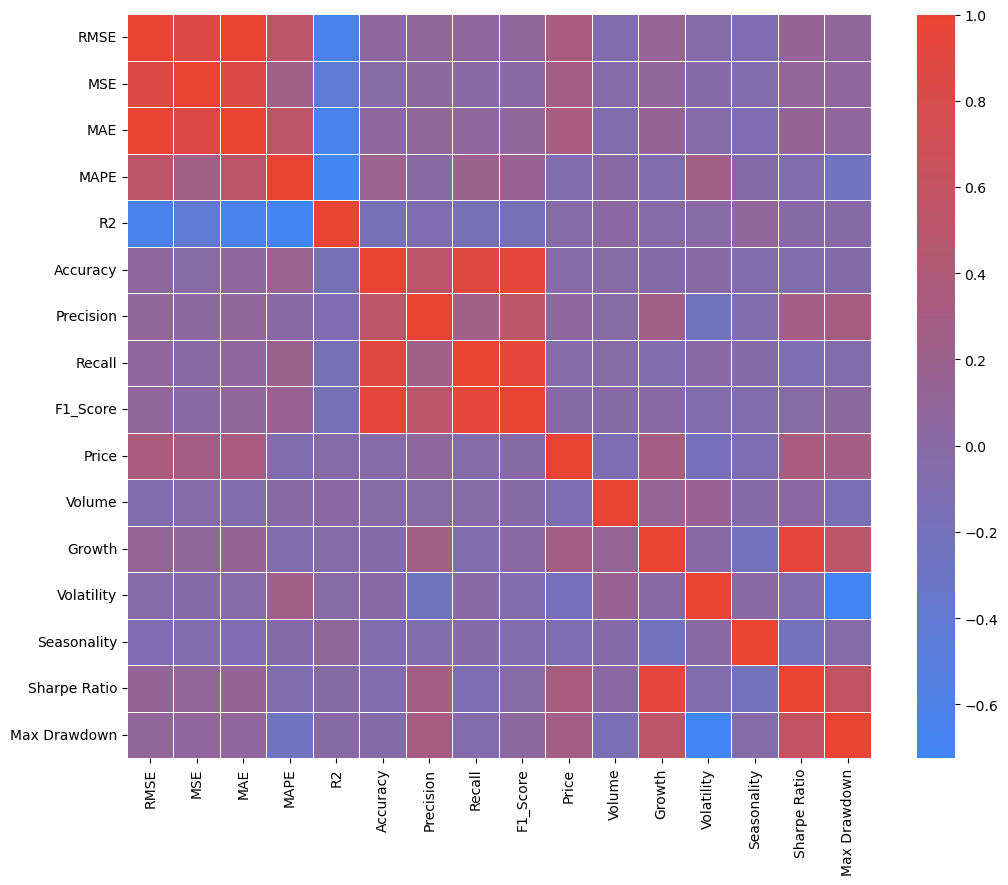

In [85]:
#@title Correlation for Characteristics and Performance Each Symbol

numeric_cols = merged_df.select_dtypes(include=[np.number]).columns
corr = merged_df[numeric_cols].corr()

custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ['#4285f4', '#ea4335'])

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=False,
    cmap=custom_cmap,
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={"orientation": "vertical", "shrink": 0.965}, 
    square=True
)

plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)

ax = plt.gca()
ax.tick_params(axis='x', which='both', bottom=True, top=False)
ax.spines['top'].set_visible(False)

plt.show()

In [86]:
#@title Extract Characteristics and Performance for each Sector

sp500 = pd.read_csv("../Data/sp500.csv")
merged_df_2 = pd.merge(merged_df, sp500[['Symbol', 'Sector']], on='Symbol', how='left')

group_cols = ['RMSE', 'MSE', 'MAE', 'MAPE', 'R2', 'Accuracy', 'Precision', 'Recall',  'F1_Score', 'Price', 'Volume', 'Growth', 'Volatility', 'Seasonality', 'Sharpe Ratio', 'Max Drawdown']
sectors_df = merged_df_2.groupby('Sector')[group_cols].mean().reset_index()

scaler = MinMaxScaler()
sectors_df_norm = sectors_df.copy()
sectors_df_norm[group_cols] = scaler.fit_transform(sectors_df[group_cols])

sectors_df_norm.head()

,Sector,RMSE,MSE,MAE,MAPE,R2,Accuracy,Precision,Recall,F1_Score,Price,Volume,Growth,Volatility,Seasonality,Sharpe Ratio,Max Drawdown
0,Consumer Discretionary,0.353381,0.134611,0.328396,0.264614,1.000000,0.371274,0.000000,0.363821,0.028686,0.577565,0.126314,0.402009,0.813757,0.684116,0.526012,0.000000
1,Consumer Staples,0.000000,0.010979,0.000000,0.227964,0.839089,0.386988,0.283076,0.387834,0.196403,0.346862,0.170406,0.133020,0.109784,0.771404,0.247458,0.641648
2,Energy,0.885279,0.173343,0.905780,1.000000,0.000000,1.000000,0.741977,1.000000,0.995930,0.152163,0.191768,1.000000,1.000000,0.000000,0.878024,0.288987
3,Financials,0.898683,0.353391,0.890104,0.314752,0.586301,0.825723,1.000000,0.723159,1.000000,0.687566,0.042452,0.914479,0.424228,0.614222,1.000000,0.687753
4,Health Care,0.846465,0.456134,0.756414,0.137669,0.885427,0.826750,0.432531,0.996893,0.786892,0.959984,0.061390,0.274884,0.331873,0.717185,0.366633,0.428913


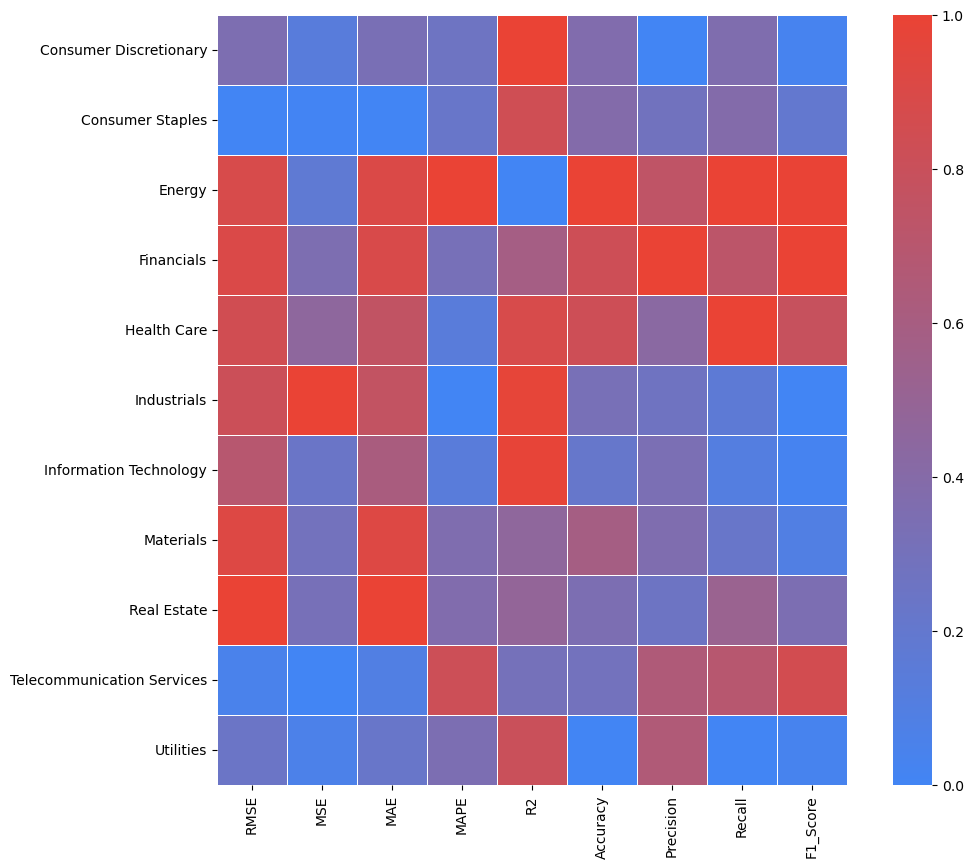

In [87]:
#@title Heatmap for Characteristics and Performance of Each Sector

ustom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ['#4285f4', '#ea4335'])
rmse_accuracy_data = sectors_df_norm[['Sector', 'RMSE', 'MSE', 'MAE', 'MAPE', 'R2', 'Accuracy', 'Precision', 'Recall',  'F1_Score']]
rmse_accuracy_data_indexed = rmse_accuracy_data.set_index('Sector')

plt.figure(figsize=(12, 10))
sns.heatmap(
    rmse_accuracy_data_indexed,
    cmap=custom_cmap,
    cbar=True,
    linewidths=0.5,      
    linecolor='white',    
    annot=False,
    square=True           
)

plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.ylabel('')  

ax = plt.gca()
ax.tick_params(axis='x', which='both', bottom=True, top=False)
ax.spines['top'].set_visible(False)

plt.show()

In [88]:
#@title Stock Prediction Performance Segmentation - PART 1

def classify_stock_prediction_performance(row):
    score = 0
    
    if row['Accuracy'] >= 65:
        score += 4
    elif row['Accuracy'] >= 60:
        score += 3
    elif row['Accuracy'] >= 55:
        score += 2
    elif row['Accuracy'] >= 50:
        score += 1
    else:
        score -= 3
    
    if row['MAPE'] <= 5:
        score += 3
    elif row['MAPE'] <= 10:
        score += 2
    elif row['MAPE'] <= 20:
        score += 1
    elif row['MAPE'] <= 50:
        score += 0
    else:
        score -= 2
    
    if row['R2'] >= 0.8:
        score += 3
    elif row['R2'] >= 0.5:
        score += 2
    elif row['R2'] >= 0.2:
        score += 1
    elif row['R2'] >= 0:
        score += 0
    else:
        score -= 2
    
    if row['F1_Score'] >= 75:
        score += 2
    elif row['F1_Score'] >= 65:
        score += 1
    elif row['F1_Score'] >= 55:
        score += 0
    else:
        score -= 1
    
    if row['Precision'] >= 80:
        score += 2
    elif row['Precision'] >= 70:
        score += 1
    elif row['Precision'] < 60:
        score -= 1
    
    if score >= 8:
        return 'Good'
    elif score >= 3:
        return 'Average'
    else:
        return 'Bad'

merged_df_2['Performance_Category'] = merged_df_2.apply(classify_stock_prediction_performance, axis=1)

good_results = merged_df_2[merged_df_2['Performance_Category'] == 'Good'].copy()
average_results = merged_df_2[merged_df_2['Performance_Category'] == 'Average'].copy()
bad_results = merged_df_2[merged_df_2['Performance_Category'] == 'Bad'].copy()

In [89]:
#@title Stock Prediction Performance Segmentation - PART 2

print("="*50)
print("STOCK PREDICTION PERFORMANCE SEGMENTATION")
print("="*50)

print(f"\n EXCELLENT STOCKS: {len(good_results)} symbols ({len(good_results)/len(merged_df_2)*100:.1f}%)")
print(f"\n DECENT STOCKS: {len(average_results)} symbols ({len(average_results)/len(merged_df_2)*100:.1f}%)")
print(f"\n POOR STOCKS: {len(bad_results)} symbols ({len(bad_results)/len(merged_df_2)*100:.1f}%)")

key_metrics = ['Symbol', 'Accuracy', 'MAPE', 'R2', 'F1_Score', 'Precision', 'Recall']

print("\n" + "="*50)
print("EXCELLENT STOCKS")
print("="*50)
if len(good_results) > 0:
    good_summary = good_results[key_metrics].round(4)
    good_summary_sorted = good_summary.sort_values(['Accuracy', 'MAPE'], ascending=[False, True])
    print(good_summary_sorted.head(10).to_string(index=False))
else:
    print("No models meet the 'Good' criteria")

print("\n" + "="*50)
print("DECENT STOCKS")
print("="*50)
if len(average_results) > 0:
    avg_summary = average_results[key_metrics].round(4)
    avg_summary_sorted = avg_summary.sort_values(['Accuracy', 'MAPE'], ascending=[False, True])
    print(avg_summary_sorted.head(10).to_string(index=False))
else:
    print("No models in average category")

print("\n" + "="*50)
print("POOR STOCKS")
print("="*50)
if len(bad_results) > 0:
    bad_summary = bad_results[key_metrics].round(4)
    bad_summary_sorted = bad_summary.sort_values(['Accuracy', 'R2'], ascending=[True, True])
    print(bad_summary_sorted.head(10).to_string(index=False))
else:
    print("No models in bad category")


print("\n" + "="*50)
print("APPLE")
print("="*50)

key_metrics = ['Symbol', 'Accuracy', 'MAPE', 'R2', 'F1_Score', 'Precision', 'Recall']
print(merged_df_2.loc[merged_df_2["Symbol"] == "AAPL", key_metrics])

STOCK PREDICTION PERFORMANCE SEGMENTATION

 EXCELLENT STOCKS: 47 symbols (11.7%)

 DECENT STOCKS: 190 symbols (47.1%)

 POOR STOCKS: 166 symbols (41.2%)

EXCELLENT STOCKS
Symbol  Accuracy   MAPE     R2  F1_Score  Precision  Recall
  NDAQ   60.1796 0.8583 0.9723   69.1415    80.1075 60.8163
   AMP   57.7844 1.0928 0.9706   68.1716    70.8920 65.6522
   AJG   57.4850 0.8628 0.9707   69.5279    70.1299 68.9362
  TRIP   57.1856 6.5711 0.5324   68.2927    70.6422 66.0944
  CSCO   56.5868 1.3641 0.9631   66.6667    73.6041 60.9244
   ICE   56.5868 2.4713 0.7464   66.9704    73.1343 61.7647
   HCA   55.9880 1.0371 0.9723   67.2606    71.5640 63.4454
   STT   55.9880 3.9850 0.6649   65.0831    72.8723 58.7983
    GS   55.6886 2.9413 0.8787   65.7407    72.0812 60.4255
   HAL   55.6886 4.9938 0.7945   62.2449    71.7647 54.9550

DECENT STOCKS
Symbol  Accuracy    MAPE       R2  F1_Score  Precision   Recall
  GILD   72.7545 38.1775  -7.9571   84.2288    72.7545 100.0000
   ESS   70.6587 36.0680 -

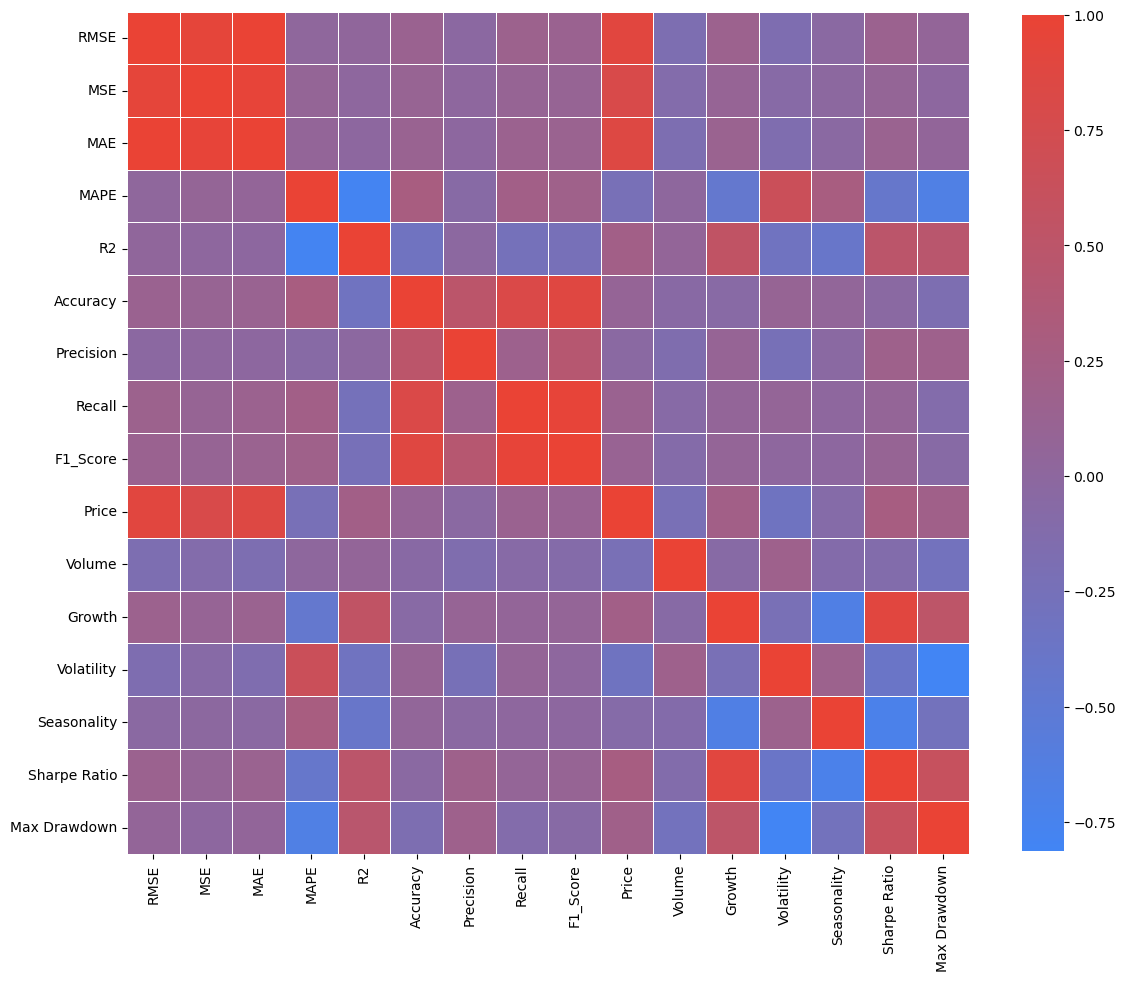

In [90]:
#@title Stock Prediction Performance Segmentation - PART 3

numeric_cols = good_results.select_dtypes(include=[np.number]).columns
corr = good_results[numeric_cols].corr()
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ['#4285f4', '#ea4335'])

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=False,
    cmap=custom_cmap,
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={"orientation": "vertical", "shrink": 0.965}, 
    square=True
)

plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
ax = plt.gca()
ax.tick_params(axis='x', which='both', bottom=True, top=False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.show()

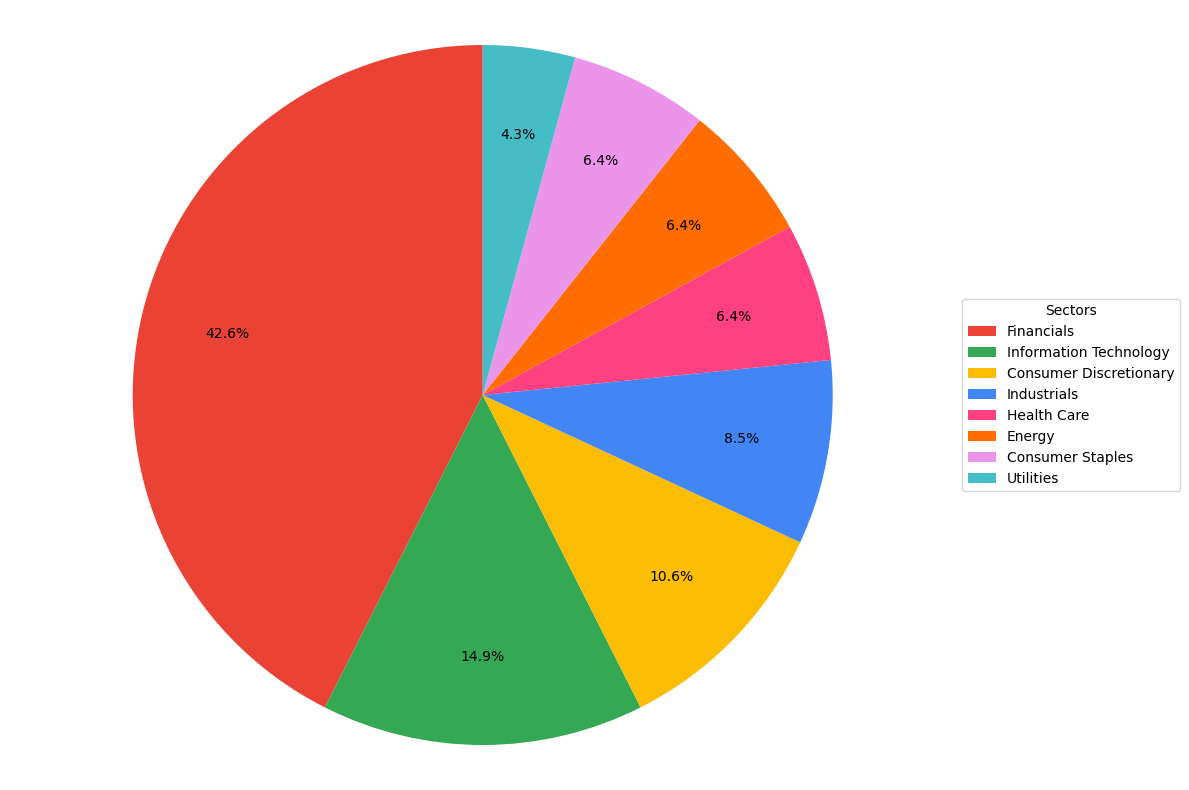

In [91]:
#@title Stock Prediction Performance Segmentation - PART 4

sector_counts = good_results['Sector'].value_counts()

strong_colors = ['#ea4335', '#34a853', '#fbbc04', '#4285f4', '#ff4081', '#ff6d01', '#ea95ea', '#46bdc6', '#8e7dc3']

plt.figure(figsize=(12, 8))
wedges, texts, autotexts = plt.pie(
    sector_counts.values,
    autopct='%1.1f%%', 
    startangle=90, 
    colors=strong_colors[:len(sector_counts)], 
    pctdistance=0.75
)

plt.legend(wedges, sector_counts.index, title="Sectors", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.axis('equal')
plt.tight_layout()
plt.show()

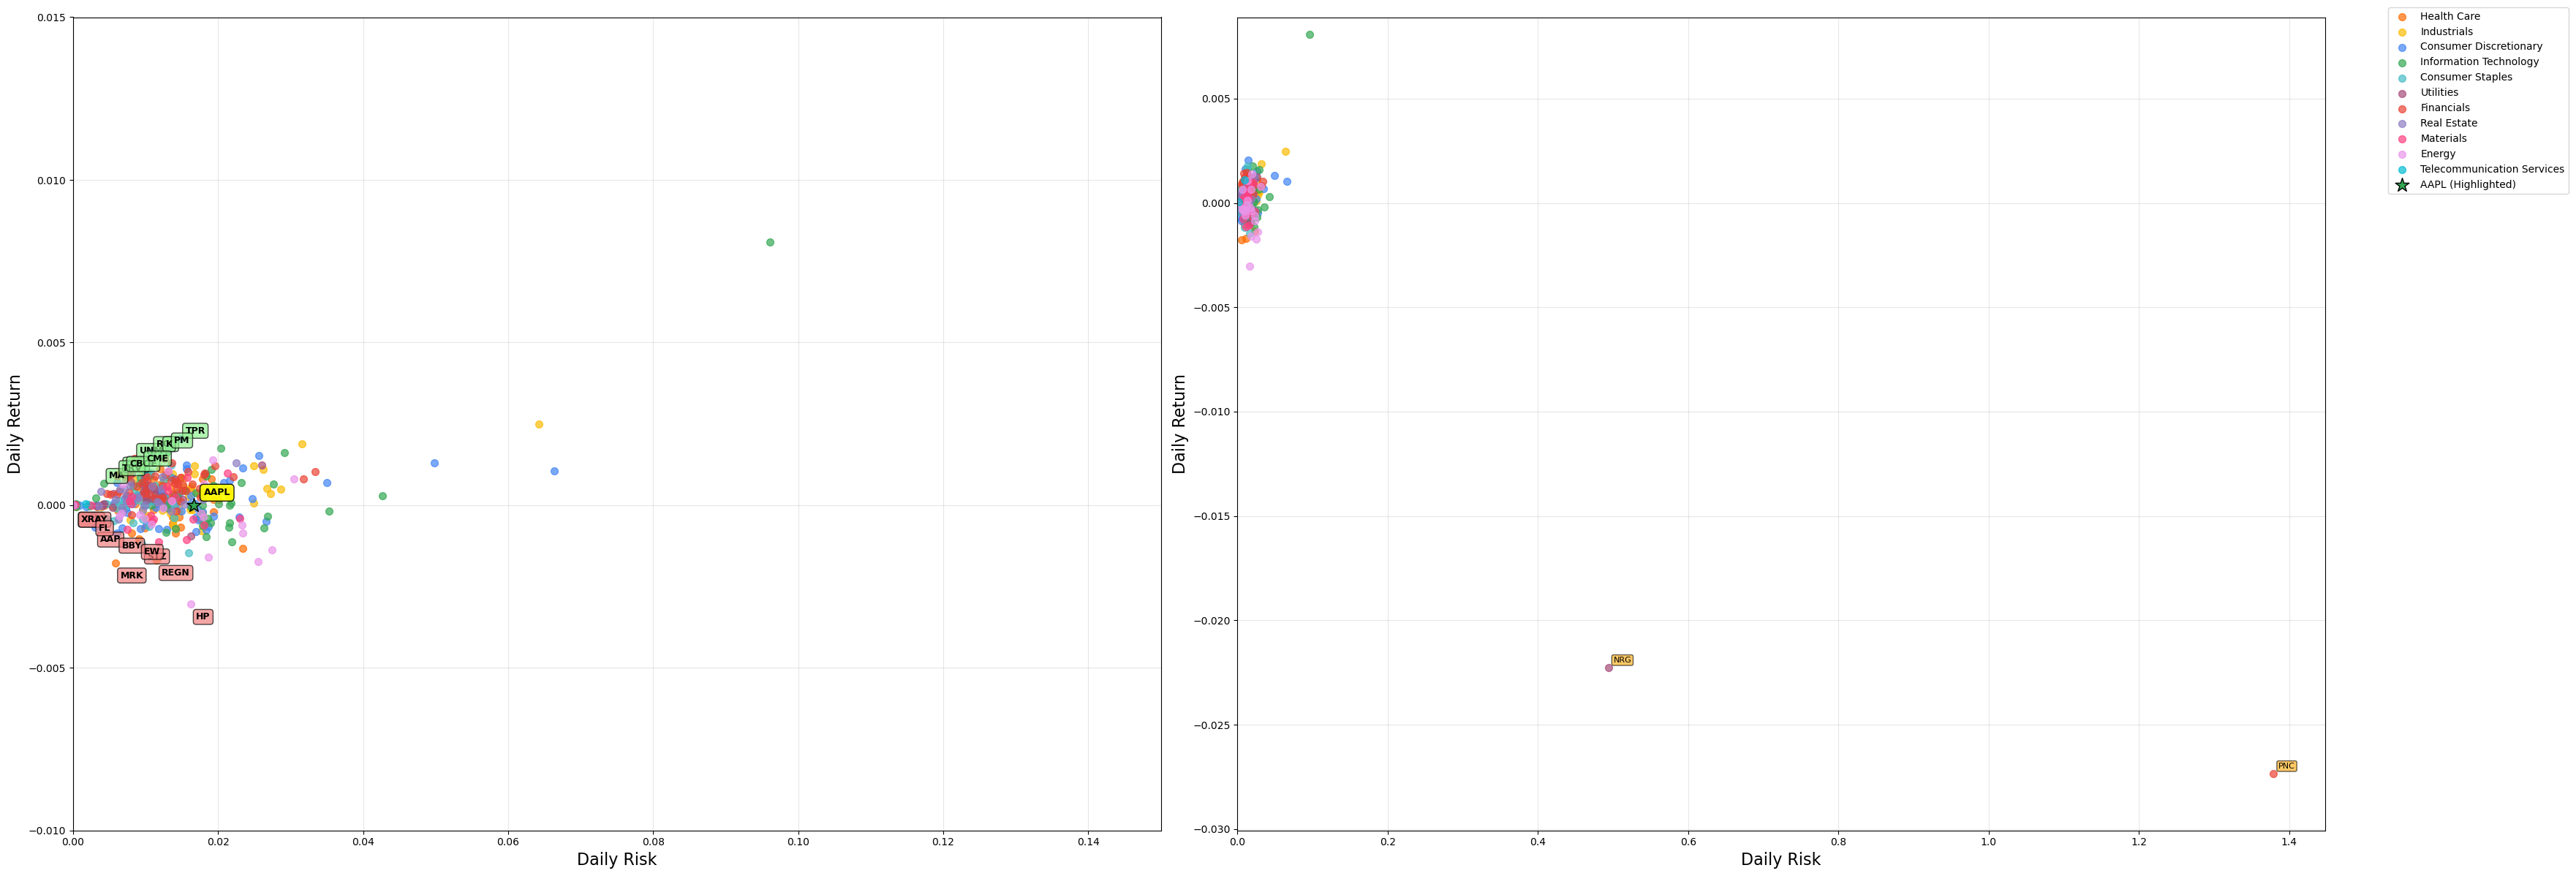

In [92]:
#@title Risk-Return Analysis - PART 1

risk_return_df = pd.read_csv("../Data/risk_return.csv")
unique_sectors = risk_return_df['Sector'].unique()

sector_colors = {
    'Consumer Discretionary': '#4285f4',  
    'Financials': '#ea4335',               
    'Industrials': '#fbbc04',           
    'Information Technology': '#34a853',  
    'Health Care': '#ff6d01',             
    'Consumer Staples': '#46bdc6',        
    'Real Estate': '#8e7dc3',             
    'Utilities': '#a64d79',               
    'Energy': '#ea95ea',                
    'Materials': '#ff4081',               
    'Telecommunication Services': '#00bcd4'  
}

risk_return_df['Risk_Return_Ratio'] = risk_return_df['Daily_Return'] / risk_return_df['Daily_Risk']
top_10 = risk_return_df.nlargest(10, 'Risk_Return_Ratio')
bottom_10 = risk_return_df.nsmallest(10, 'Risk_Return_Ratio')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 12))

for sector in unique_sectors:
    sector_data = risk_return_df[risk_return_df['Sector'] == sector]
    ax1.scatter(sector_data['Daily_Risk'], 
               sector_data['Daily_Return'], 
               c=sector_colors[sector], 
               label=sector, 
               alpha=0.7, 
               s=50)

for idx, row in top_10.iterrows():
    ax1.annotate(row['Symbol'], 
                (row['Daily_Risk'], row['Daily_Return']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7),
                ha='left')

for idx, row in bottom_10.iterrows():
    ax1.annotate(row['Symbol'], 
                (row['Daily_Risk'], row['Daily_Return']),
                xytext=(5, -15), textcoords='offset points',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7),
                ha='left')

aapl_data = risk_return_df[risk_return_df['Symbol'] == 'AAPL']
if not aapl_data.empty:
    ax1.scatter(aapl_data['Daily_Risk'].iloc[0], 
               aapl_data['Daily_Return'].iloc[0], 
               c='#34a853',  
               s=200,  
               marker='*',  
               edgecolors='black',
               linewidth=1,
               label='AAPL (Highlighted)',
               zorder=10) 
    ax1.annotate('AAPL', 
                (aapl_data['Daily_Risk'].iloc[0], aapl_data['Daily_Return'].iloc[0]),
                xytext=(10, 10), textcoords='offset points',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.9, edgecolor='black'),
                ha='left',
                zorder=11)

ax1.set_xlim(0, 0.15)
ax1.set_ylim(-0.01, 0.015)
ax1.set_xlabel('Daily Risk', fontsize=16)
ax1.set_ylabel('Daily Return', fontsize=16)
ax1.grid(True, alpha=0.3)

for sector in unique_sectors:
    sector_data = risk_return_df[risk_return_df['Sector'] == sector]
    ax2.scatter(sector_data['Daily_Risk'], 
               sector_data['Daily_Return'], 
               c=sector_colors[sector], 
               alpha=0.7, 
               s=50)

extreme_outliers = risk_return_df[
    (risk_return_df['Daily_Risk'] > 0.1) | 
    (risk_return_df['Daily_Return'] > 0.01) | 
    (risk_return_df['Daily_Return'] < -0.01)
]

for idx, row in extreme_outliers.iterrows():
    ax2.annotate(row['Symbol'], 
                (row['Daily_Risk'], row['Daily_Return']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, 
                bbox=dict(boxstyle='round,pad=0.2', facecolor='orange', alpha=0.6),
                ha='left')

ax2.set_xlim(0, risk_return_df['Daily_Risk'].max() * 1.05)
ax2.set_ylim(risk_return_df['Daily_Return'].min() * 1.1, risk_return_df['Daily_Return'].max() * 1.1)
ax2.set_xlabel('Daily Risk', fontsize=16)
ax2.set_ylabel('Daily Return', fontsize=16)
ax2.grid(True, alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

In [93]:
#@title Risk-Return Analysis - PART 2

merged_df_2 = merged_df_2.merge(risk_return_df[['Symbol', 'Risk_Return_Ratio']], on='Symbol', how='left')
column = 'Risk_Return_Ratio'
chars = ['Price', 'Volume', 'Growth', 'Volatility', 'Seasonality', 'Sharpe Ratio', 'Max Drawdown']

print(f"\n{'='*50}")
print(f"{column.upper()}")
print(f"{'='*50}")

print(f"\nTop 10 HIGHEST {column}:")
print("-" * 30)
top_max = merged_df_2.nlargest(10, column)
for idx, row in top_max.iterrows():
    print(f"\nSymbol: {row['Symbol']}")
    print(row[chars].to_string())

print(f"\nTop 10 LOWEST {column}:")
print("-" * 30)
top_min = merged_df_2.nsmallest(10, column)
for idx, row in top_min.iterrows():
    print(f"\nSymbol: {row['Symbol']}")
    print(row[chars].to_string())


RISK_RETURN_RATIO

Top 10 HIGHEST Risk_Return_Ratio:
------------------------------

Symbol: UNM
Price               81.71
Volume          1073295.0
Growth           0.384788
Volatility       0.018869
Seasonality      0.006336
Sharpe Ratio     0.056681
Max Drawdown    -0.298433

Symbol: MA
Price               585.6
Volume          4581210.0
Growth            0.14215
Volatility       0.013474
Seasonality      0.021204
Sharpe Ratio     0.033767
Max Drawdown    -0.285747

Symbol: CAH
Price              154.44
Volume          2759522.0
Growth           0.230847
Volatility       0.013393
Seasonality      0.010674
Sharpe Ratio     0.049236
Max Drawdown     -0.26561

Symbol: RCL
Price              256.97
Volume          3481946.0
Growth           0.358226
Volatility       0.028511
Seasonality      0.013005
Sharpe Ratio     0.043462
Max Drawdown    -0.677459

Symbol: TRV
Price               275.7
Volume          2689938.0
Growth           0.203723
Volatility       0.012498
Seasonality      0.

In [94]:
#@title Risk-Return Analysis - PART 3

top_50_df = merged_df_2.nlargest(50, 'Risk_Return_Ratio').reset_index(drop=True)

metrics = ['Price', 'Volume', 'Growth', 'Volatility', 'Seasonality', 'Sharpe Ratio', 'Max Drawdown']

top_50_averages = top_50_df[metrics].mean()
merged_averages = merged_df[metrics].mean()

comparison_df = pd.DataFrame({
    'Top_50_Average': top_50_averages,
    'All_Stocks_Average': merged_averages
})

comparison_df['Difference'] = comparison_df['Top_50_Average'] - comparison_df['All_Stocks_Average']
comparison_df['Percentage_Difference'] = (comparison_df['Difference'] / comparison_df['All_Stocks_Average']) * 100

print("=== COMPARISON OF AVERAGES ===")
print(comparison_df.round(4))

=== COMPARISON OF AVERAGES ===
              Top_50_Average  All_Stocks_Average    Difference  \
Price           2.662610e+02        1.731431e+02  9.311790e+01   
Volume          7.023553e+06        9.246145e+06 -2.222593e+06   
Growth          1.584000e-01        9.660000e-02  6.180000e-02   
Volatility      1.460000e-02        1.670000e-02 -2.200000e-03   
Seasonality     3.500000e-02        4.220000e-02 -7.200000e-03   
Sharpe Ratio    3.490000e-02        2.340000e-02  1.140000e-02   
Max Drawdown   -3.796000e-01       -4.592000e-01  7.960000e-02   

              Percentage_Difference  
Price                       53.7809  
Volume                     -24.0380  
Growth                      63.9114  
Volatility                 -13.0740  
Seasonality                -16.9779  
Sharpe Ratio                48.7777  
Max Drawdown               -17.3324  


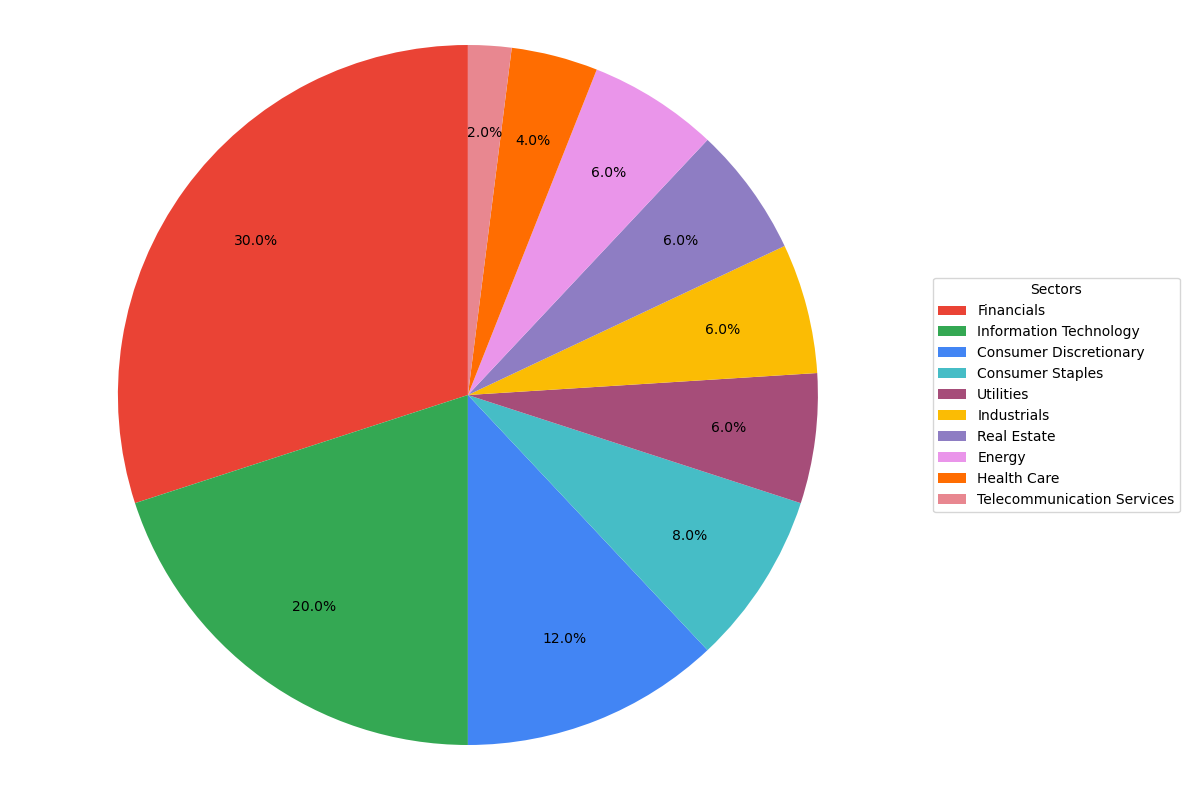

In [105]:
#@title Risk-Return Analysis - PART 4

sector_counts = top_50_df['Sector'].value_counts()
strong_colors = ['#ea4335', '#34a853', '#4285f4', '#46bdc6', '#a64d79', '#fbbc04', '#8e7dc3', '#ea95ea', '#ff6d01', '#e88790']
                 
plt.figure(figsize=(12, 8))
wedges, texts, autotexts = plt.pie(
    sector_counts.values,
    autopct='%1.1f%%', 
    startangle=90, 
    colors=strong_colors[:len(sector_counts)], 
    pctdistance=0.75
)

plt.legend(wedges, sector_counts.index, title="Sectors", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.axis('equal')
plt.tight_layout()
plt.show()